In [ ]:
# This notebook will leverage nursing data from CMS to draw on several insights

# Nursing Burnout and its impact on Nurse Lifestyles
# https://ldi.upenn.edu/our-work/research-updates/how-inadequate-hospital-staffing-continues-to-burn-out-nurses-and-threaten-patients/#:~:text=Before%20the%20pandemic%2C%2064.9%25%20of,to%2058.9%25%20during%20the%20pandemic.

# Data Methodology
# https://data.cms.gov/resources/payroll-based-journal-methodology-0

# Data Dictionaries / Glossaries / indexes
# https://data.cms.gov/resources/payroll-based-journal-daily-non-nurse-staffing-data-dictionary
# https://data.cms.gov/resources/payroll-based-journal-daily-nurse-staffing-data-dictionary
# https://www.kaggle.com/datasets/miadul/overstimulation-behavior-and-lifestyle-dataset
# https://www.kaggle.com/datasets/manuelcamachor/level-of-anxiety-in-nursing-during-covid-pandemic

# Datasets
# https://data.cms.gov/quality-of-care/payroll-based-journal-daily-non-nurse-staffing/data
# https://data.cms.gov/quality-of-care/payroll-based-journal-daily-nurse-staffing/data
# https://www.kaggle.com/datasets/miadul/overstimulation-behavior-and-lifestyle-dataset
# https://www.kaggle.com/datasets/manuelcamachor/level-of-anxiety-in-nursing-during-covid-pandemic

# Hypothesis
# Using a combination of real and synthetic data, we aspire to show that nurses who work in under-staffed medical settings, experience negative lifestyle effects by being overstimulated / having a low nurse to patient index (something like this - explore the data)

In [ ]:
## Task:
#1. Data Familiarity & Exploration  
# • Load and explore the dataset (can be any public dataset or one provided by you – e.g., UCI, Kaggle). 
# • Identify key trends and what the data might say about the user. 

#2. Build a Simple Model  
# • Choose a modeling goal: e.g., user segmentation, outcome prediction, or recommendation. 
# • Select and justify a model (logistic regression, decision trees, simple neural net, etc.). 
# • Train and validate (simple train/test split is fine). 

#3. Evaluate & Explain  
# • Use one or two performance metrics (e.g., accuracy, F1, ROC AUC). 
# • Explain the why behind your modeling choices. 
# • Summarize key insights (via comments, markdown, or a short PDF summary). 

#4. Final Thoughts  
# • Briefly discuss how you’d productionize this in a startup setting.

In [1]:
# Setup
!pip install polars


DEPRECATION: Loading egg at c:\users\tmele\anaconda3\lib\site-packages\mask_rcnn-2.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


## Get Data


In [27]:
# This Section is just for me to download the source data, the included datasets replace these files and are much smaller. There's no need to use this section other than to review how the api was accessed to download the data.

# Getting the data via api
import polars as pl
import requests
import os
import time

# define datasets for api acquisition
non_nursing_data = [
    {
        "type": "Non-Nursing Staffing",
        "quarter": "Q3",
        "year": "2024",
        "id": "293788f3-20a9-4ebd-ab4a-9989325ce3e7"
    },
    {
        "type": "Non-Nursing Staffing",
        "quarter": "Q2",
        "year": "2024",
        "id": "c06ad548-5cb2-4f29-8075-66efc2d195b6"
    },
    {
        "type": "Non-Nursing Staffing",
        "quarter": "Q1",
        "year": "2024",
        "id": "86603f7e-6ed8-4005-a5d3-b13d2ebcf3d4"
    }
]
non_nursing_data = [non_nursing_data[2]]
nursing_data = [
    {
        "type": "Nursing Staffing",
        "quarter": "Q3",
        "year": "2024",
        "id": "989fbc78-1655-487d-9f24-d68e9a0ab3af"
    },
    {
        "type": "Nursing Staffing",
        "quarter": "Q2",
        "year": "2024",
        "id": "dcc467d8-5792-4e5d-95be-04bf9fc930a1"
    },
    {
        "type": "Nursing Staffing",
        "quarter": "Q1",
        "year": "2024",
        "id": "5b84bdf2-b246-4b3c-be1b-cf7c2bcb3391"
    }
]
nursing_data = [nursing_data[2]]

data_sets = nursing_data #+ non_nursing_data

# optional
data_frames = []

# directory of where this notebook will be run
base_dir = os.getcwd()+"\\data\\"

# avoid extra api calls
for item in data_sets:
    file = [str(val) for val in item.values()]
    file = "-".join(file)+".tsv"
    this_file = base_dir+file
    
    if os.path.exists(this_file):
        pass # df = pl.read_csv(this_file, separator='\t')
        # data_frames.append(df)
    else:
        _id = item['id']
        
        # get the base url
        api_url = "https://data.cms.gov/data-api/v1/dataset/"+_id+"/data"
        
        # places to store data
        _data = []
        
        # get number of rows
        response = requests.get(api_url+"/stats")
        rows = response.json()
        total_rows = rows.get("total_rows")
        i = 0 
        
        # api docs stated they can provide 5k per call but only 1k is in the response
        print(f"obtaining {total_rows} rows 1000 at a time")
        while i < total_rows: 
            size = 1000
            offset_url = f"{api_url}?/size={size}&offset={i}"
            offset = i
            offset_response = requests.get(offset_url)
            print(f"Made request for {size} results at offset {i}")
            items = offset_response.json()
            for item in items:
                _data.append(item)
            i = i+size
            print(["Size is now:",len(_data)])
            time.sleep(0.5)     
            
        df = pl.DataFrame(_data)
        df.write_csv(this_file,include_header=True,separator="\t",line_terminator="\n",quote_char='"',null_value="NA")
        time.sleep(120)


ConnectionError: HTTPSConnectionPool(host='data.cms.gov', port=443): Max retries exceeded with url: /data-api/v1/dataset/5b84bdf2-b246-4b3c-be1b-cf7c2bcb3391/data/stats (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000028E46867EC0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [7]:
# this exists for validation as much as a way to label things and for validation. It is useful.
data_definitions = {
    "PROVNUM": "Medicare provider number",
    "PROVNAME": "Provider name",
    "CITY": "Provider City",
    "STATE": "Postal abbreviation for State",
    "COUNTY_NAME": "Name of Provider County, unique within state",
    "COUNTY_FIPS": "FIPS Code for Provider County, unique within state",
    "CY_Qtr": "Calendar Quarter (yyyyQq, e.g. 2018Q4)",
    "WorkDate": "Day for Reported Hours (yyyymmdd)",
    "MDScensus": "Resident Census from MDS",
    "Hrs_RNDON": "Total Hours for RN Director of Nursing", # no EMP?
    "Hrs_RNDON_emp": "Employee Hours for RN Director of Nursing", # this was missing and confirmed below
    "Hrs_RNDON_ctr": "Contract Hours for RN Director of Nursing",
    "Hrs_RNadmin": "Hours for RN with administrative duties",
    "Hrs_RNadmin_emp": "Employee Hours for RN with administrative duties",
    "Hrs_RNadmin_ctr": "Contract Hours for RN with administrative duties",
    "Hrs_RN": "Total Hours for RN",
    "Hrs_RN_emp": "Employee Hours for RN",
    "Hrs_RN_ctr": "Contract Hours for RN",
    "Hrs_LPNadmin": "Total Hours for LPN w/ admin duties",
    "Hrs_LPNadmin_emp": "Employee Hours for LPN w/ admin duties",
    "Hrs_LPNadmin_ctr": "Contract Hours for LPN w/ admin duties",
    "Hrs_LPN": "Total Hours for LPN",
    "Hrs_LPN_emp": "Employee Hours for LPN",
    "Hrs_LPN_ctr": "Contract Hours for LPN",
    "Hrs_CNA": "Total Hours for CNA",
    "Hrs_CNA_emp": "Employee Hours for CNA",
    "Hrs_CNA_ctr": "Contract Hours for CNA",
    "Hrs_NAtrn": "Total Hours for Nurse aide in training",
    "Hrs_NAtrn_emp": "Employee Hours for Nurse aide in training",
    "Hrs_NAtrn_ctr": "Contract Hours for Nurse aide in training",
    "Hrs_MedAide": "Total Hours for Med Aide/Technician",
    "Hrs_MedAide_emp": "Employee Hours for Med Aide/Technician",
    "Hrs_MedAide_ctr": "Contract Hours for Med Aide/Technician",
    #
    "Hrs_Admin": "Total Hours for Administrator",
    "Hrs_Admin_emp": "Employee Hours for Administrator",
    "Hrs_Admin_ctr": "Contract Hours for Administrator",
    "Hrs_Admin fn": "Footnote for Administrator Hours worked: 1 = Provider submitted invalid administrator hours",
    "Hrs_MedDir": "Total Hours for Medical Director",
    "Hrs_MedDir_emp": "Employee Hours for Medical Director",
    "Hrs_MedDir_ctr": "Contract Hours for Medical Director",
    "Hrs_OthMD": "Total Hours for Other Physician",
    "Hrs_OthMD_emp": "Employee Hours for Other Physician",
    "Hrs_OthMD_ctr": "Contract Hours for Other Physician",
    "Hrs_PA": "Total Hours for Physician Assistant",
    "Hrs_PA_emp": "Employee Hours for Physician Assistant",
    "Hrs_PA_ctr": "Contract Hours for Physician Assistant",
    "Hrs_NP": "Total Hours for Nurse Practitioner",
    "Hrs_NP_emp": "Employee Hours for Nurse Practitioner",
    "Hrs_NP_ctr": "Contract Hours for Nurse Practitioner",
    "Hrs_ClinNrsSpec": "Total Hours for Clinical Nurse Specialist",
    "Hrs_ClinNrsSpec_emp": "Employee Hours for Clinical Nurse Specialist",
    "Hrs_ClinNrsSpec_ctr": "Contract Hours for Clinical Nurse Specialist",
    "Hrs_Pharmacist": "Total Hours for Pharmacist",
    "Hrs_Pharmacist_emp": "Employee Hours for Pharmacist",
    "Hrs_Pharmacist_ctr": "Contract Hours for Pharmacist",
    "Hrs_Dietician": "Total Hours for Dietician",
    "Hrs_Dietician_emp": "Employee Hours for Dietician",
    "Hrs_Dietician_ctr": "Contract Hours for Dietician",
    "Hrs_FeedAsst": "Total Hours for Feeding Assistant",
    "Hrs_FeedAsst_emp": "Employee Hours for Feeding Assistant",
    "Hrs_FeedAsst_ctr": "Contract Hours for Feeding Assistant",
    "Hrs_OT": "Total Hours for Occupational Therapist",
    "Hrs_OT_emp": "Employee Hours for Occupational Therapist",
    "Hrs_OT_ctr": "Contract Hours for Occupational Therapist",
    "Hrs_OTasst": "Total Hours for Occupational Therapy Assistant",
    "Hrs_OTasst_emp": "Employee Hours for Occupational Therapy Assistant",
    "Hrs_OTasst_ctr": "Contract Hours for Occupational Therapy Assistant",
    "Hrs_OTaide": "Total Hours for Occupational Therapy Aide",
    "Hrs_OTaide_emp": "Employee Hours for Occupational Therapy Aide",
    "Hrs_OTaide_ctr": "Contract Hours for Occupational Therapy Aide",
    "Hrs_PT": "Total Hours for Physical Therapist",
    "Hrs_PT_emp": "Employee Hours for Physical Therapist",
    "Hrs_PT_ctr": "Contract Hours for Physical Therapist",
    "Hrs_PTasst": "Total Hours for Physical Therapy Assistant",
    "Hrs_PTasst_emp": "Employee Hours for Physical Therapy Assistant",
    "Hrs_PTasst_ctr": "Contract Hours for Physical Therapy Assistant",
    "Hrs_PTaide": "Total Hours for Physical Therapy Aide",
    "Hrs_PTaide_emp": "Employee Hours for Physical Therapy Aide",
    "Hrs_PTaide_ctr": "Contract Hours for Physical Therapy Aide",
    "Hrs_RespTher": "Total Hours for Respiratory Therapist",
    "Hrs_RespTher_emp": "Employee Hours for Respiratory Therapist",
    "Hrs_RespTher_ctr": "Contract Hours for Respiratory Therapist",
    "Hrs_RespTech": "Total Hours for Respiratory Therapy Technician",
    "Hrs_RespTech_emp": "Employee Hours for Respiratory Therapy Technician",
    "Hrs_RespTech_ctr": "Contract Hours for Respiratory Therapy Technician",
    "Hrs_SpcLangPath": "Total Hours for Speech/Language Pathologist",
    "Hrs_SpcLangPath_emp": "Employee Hours for Speech/Language Pathologist",
    "Hrs_SpcLangPath_ctr": "Contract Hours for Speech/Language Pathologist",
    "Hrs_TherRecSpec": "Total Hours for Therapeutic Recreation Specialist",
    "Hrs_TherRecSpec_emp": "Employee Hours for Therapeutic Recreation Specialist",
    "Hrs_TherRecSpec_ctr": "Contract Hours for Therapeutic Recreation Specialist",
    "Hrs_QualActvProf": "Total Hours for Qualified Activities Professional",
    "Hrs_QualActvProf_emp": "Employee Hours for Qualified Activities Professional",
    "Hrs_QualActvProf_ctr": "Contract Hours for Qualified Activities Professional",
    "Hrs_OthActv": "Total Hours for Other Activities Staff",
    "Hrs_OthActv_emp": "Employee Hours for Other Activities Staff",
    "Hrs_OthActv_ctr": "Contract Hours for Other Activities Staff",
    "Hrs_QualSocWrk": "Total Hours for Qualified Social Worker",
    "Hrs_QualSocWrk_emp": "Employee Hours for Qualified Social Worker",
    "Hrs_QualSocWrk_ctr": "Contract Hours for Qualified Social Worker",
    "Hrs_OthSocWrk": "Total Hours for Other Social Worker",
    "Hrs_OthSocWrk_emp": "Employee Hours for Other Social Worker",
    "Hrs_OthSocWrk_ctr": "Contract Hours for Other Social Worker",
    "Hrs_MHSvc": "Total Hours for Mental Health Service Worker",
    "Hrs_MHSvc_emp": "Employee Hours for Mental Health Service Worker",
    "Hrs_MHSvc_ctr": "Contract Hours for Mental Health Service Worker"
}   

In [192]:
# Transform Data into smaller usable components for analysis
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import os


#pl.Config.set_tbl_width_chars(100)
#pl.Config.set_fmt_str_lengths(100)

# directory of where this notebook will be run
base_dir = os.getcwd()+"\\data\\"

nurses = pl.read_csv(base_dir+"Nursing Staffing-Q1-2024-5b84bdf2-b246-4b3c-be1b-cf7c2bcb3391.tsv", separator="\t", infer_schema_length=10000,ignore_errors=True)
non_nurses = pl.read_csv(base_dir+"Non-Nursing Staffing-Q2-2024-86603f7e-6ed8-4005-a5d3-b13d2ebcf3d4.tsv", separator="\t", infer_schema_length=10000,ignore_errors=True)
provider_info = pl.read_csv(base_dir+"Provider_Info.csv")


################################################## Inspect/Prepare Data ##################################################
################################################## Inspect/Prepare Data ##################################################

# let's work with good samples
nurses = nurses.filter(pl.col("PROVNUM").is_not_null())
non_nurses = non_nurses.filter(pl.col("PROVNUM").is_not_null())

# I noticed the WorkDate and date processed col is not a date, string with date
# strings
nurses = nurses.with_columns(pl.col("WorkDate").cast(pl.Utf8).alias("WorkDate"))
non_nurses = non_nurses.with_columns(pl.col("WorkDate").cast(pl.Utf8).alias("WorkDate"))
# date
nurses = nurses.with_columns(pl.col("WorkDate").str.strptime(pl.Date, "%Y%m%d").alias("WorkDate"))
non_nurses = non_nurses.with_columns(pl.col("WorkDate").str.strptime(pl.Date, "%Y%m%d").alias("WorkDate"))
provider_info = provider_info.with_columns(pl.col("Processing Date").str.strptime(pl.Date, "%m/%d/%Y").alias("Processing Date"))

# the max provnum is for prov 335232, the data dict does not explicitly state the emp and ctr fields add to total
# this could be assumed but, check first to ensure understanding is clear. these three expression yield this is true
# and our thinking was correct. Every role in the data follows this format so that clears up basically all the fields
_nurses = nurses.group_by("PROVNUM").agg(pl.sum('Hrs_RN').alias('Registered Nurses')).sort('Registered Nurses', descending=True)
print("Total Hours:",_nurses[0]["Registered Nurses"][0])

__nurses = nurses.group_by("PROVNUM").agg(pl.sum('Hrs_RN_emp').alias('Registered Nurses emp')).filter(pl.col('PROVNUM') == 335232)
print("Employee Hours:",__nurses[0]["Registered Nurses emp"][0])

___nurses = nurses.group_by("PROVNUM").agg(pl.sum('Hrs_RN_ctr').alias('Registered Nurses ctr')).filter(pl.col('PROVNUM') == 335232)
print("Contract Hours:",___nurses[0]["Registered Nurses ctr"][0])

# is the difference really small because of rounding only
if _nurses[0]["Registered Nurses"][0] - __nurses[0]["Registered Nurses emp"][0] - ___nurses[0]["Registered Nurses ctr"][0] < 1:
    print("Employee and contract hours equal total hours")
else:
    print(False)

# this field from non nurses is different   
#    "Hrs_Admin fn": "Footnote for Administrator Hours worked: 1 = Provider submitted invalid administrator hours",
# what do they mean by this, inspect 
_non_nurses = non_nurses.filter(pl.col("Hrs_Admin_fn") != "1")['Hrs_Admin_fn']
no_mistake = len(_non_nurses)
_non_nurses = non_nurses.filter(pl.col("Hrs_Admin_fn") == "1")['Hrs_Admin_fn']
mistake = len(_non_nurses)

print("the % of mistakes in the Admin field is:", mistake/no_mistake*100) # <1% is basically irrelevant, but could have been

# I don't see a "Hrs_RNDON_emp" in my data dictionary above - lets check if I missed copying it or if it is not there
if "Hrs_RNDON_emp" in nurses.columns:
    print("Hrs_RNDON_emp is in nurses")
# it is in the columns, I made a copy/paste error in making my data dict - I will add it back and note it


Total Hours: 45625.189999999995
Employee Hours: 35137.75000000001
Contract Hours: 10487.44
Employee and contract hours equal total hours
the % of mistakes in the Admin field is: 0.6361856823266219
Hrs_RNDON_emp is in nurses


In [210]:
################################################## Data Insights ##################################################
################################################## Data Insights ##################################################

##################################################     Story     ##################################################
# Basically I am thinking that information about a provider (`Provider Info`.csv) is predictive in whether or 
# not a nursing home would use contract vs employee workers. For a traveling nurse, knowing just these few variables
# would help them understand if they will be able to work and live in that city/place, impacting their lifestyle.
# fuck idk, i dont love it, ill try it i guess
##################################################     Story     ##################################################

show=False
def total_hours():
    # make two collections of workers, one for nurses one for non nurses
    _nurse_workers = []
    _non_nurse_workers = []
    
    f=0# this flag flips when I stop seeing unique worker fields from nurses dataset
    for k,v in data_definitions.items():
        if f == 0:
            if 'Hrs' in k and 'emp' not in k and 'ctr' not in k and 'fn' not in k and "DON" not in k and "admin" not in k:
                _nurse_workers.append(k)
        else:
            if 'Hrs' in k and 'emp' not in k and 'ctr' not in k and 'fn' not in k:
                _non_nurse_workers.append(k)
        if 'MedAide' in k and 'ctr' in k:
            f=1
    return _nurse_workers, _non_nurse_workers

def employee_hours():
    # make two collections of workers, one for nurses one for non nurses
    _nurse_workers = []
    _non_nurse_workers = []
    
    f=0# this flag flips when I stop seeing unique worker fields from nurses dataset
    for k,v in data_definitions.items():
        if f == 0:
            if 'Hrs' in k and 'emp' in k and 'ctr' not in k and 'fn' not in k and "DON" not in k and "admin" not in k:
                _nurse_workers.append(k)
        else:
            if 'Hrs' in k and 'emp' in k and 'ctr' not in k and 'fn' not in k:
                _non_nurse_workers.append(k)
        if 'MedAide' in k and 'ctr' in k:
            f=1
    return _nurse_workers, _non_nurse_workers

def contract_hours():
    # make two collections of workers, one for nurses one for non nurses
    _nurse_workers = []
    _non_nurse_workers = []
    
    f=0# this flag flips when I stop seeing unique worker fields from nurses dataset
    for k,v in data_definitions.items():
        if f == 0:
            if 'Hrs' in k and 'emp' not in k and 'ctr' in k and 'fn' not in k and "DON" not in k and "admin" not in k:
                _nurse_workers.append(k)
        else:
            if 'Hrs' in k and 'emp' not in k and 'ctr' in k and 'fn' not in k:
                _non_nurse_workers.append(k)
        if 'MedAide' in k and 'ctr' in k:
            f=1
    return _nurse_workers, _non_nurse_workers

# fields
tot_n, tot_nn = total_hours()
emp_n, emp_nn = employee_hours()
ctr_n, ctr_nn = contract_hours()

print(tot_n)
print(emp_n)
print(ctr_n)

# scrapping the non-nurse angleal

X = 150000

# Total work of nurses
total_work = nurses.group_by("PROVNAME").agg(pl.mean(tot_n)).with_columns(total_work=pl.sum_horizontal(tot_n)).sort('total_work', descending=True)
#print(total_work.head())

# top X facilities with the highest total nursing hours
top_X_n = list(nurses.group_by("PROVNAME").agg(pl.mean(tot_n)).with_columns(total_work=pl.sum_horizontal(tot_n)).sort('total_work', descending=True).head(X)["PROVNAME"])

#print("top X facilities with the highest total nursing hours")
#print(top_X_n)

# of those ten, what is the % of employee to contract workers
# employee & contract
top_X_nurses = nurses.filter(pl.col("PROVNAME").is_in(top_X_n))

top_X_emp_ctr = top_X_nurses.with_columns(
    (pl.col(emp_n[0]) / pl.col(tot_n[0]) * 100).round(2).alias('%emp'+emp_n[0]).fill_nan(None),
    (pl.col(emp_n[1]) / pl.col(tot_n[1]) * 100).round(2).alias('%emp'+emp_n[1]).fill_nan(None),
    (pl.col(emp_n[2]) / pl.col(tot_n[2]) * 100).round(2).alias('%emp'+emp_n[2]).fill_nan(None),
    (pl.col(emp_n[3]) / pl.col(tot_n[3]) * 100).round(2).alias('%emp'+emp_n[3]).fill_nan(None),
    (pl.col(emp_n[4]) / pl.col(tot_n[4]) * 100).round(2).alias('%emp'+emp_n[4]).fill_nan(None),
    (pl.col(ctr_n[0]) / pl.col(tot_n[0]) * 100).round(2).alias('%ctr'+ctr_n[0]).fill_nan(None),
    (pl.col(ctr_n[1]) / pl.col(tot_n[1]) * 100).round(2).alias('%ctr'+ctr_n[1]).fill_nan(None),
    (pl.col(ctr_n[2]) / pl.col(tot_n[2]) * 100).round(2).alias('%ctr'+ctr_n[2]).fill_nan(None),
    (pl.col(ctr_n[3]) / pl.col(tot_n[3]) * 100).round(2).alias('%ctr'+ctr_n[3]).fill_nan(None),
    (pl.col(ctr_n[4]) / pl.col(tot_n[4]) * 100).round(2).alias('%ctr'+ctr_n[4]).fill_nan(None),
).select(
    ["PROVNAME"]+
    ["%emp"+val for val in emp_n]+
    ["%ctr"+val for val in ctr_n]
).group_by("PROVNAME").agg(pl.mean(["%emp"+val for val in emp_n]+["%ctr"+val for val in ctr_n]))

# fix visual showing percentage of work done by contract and employee nurses
#fig = px.bar(top_X_emp_ctr.to_pandas(), x='PROVNAME', y=["%emp"+val for val in emp_n]+["%ctr"+val for val in ctr_n], color='PROVNAME', barmode='group', title='Fruit Sales in 2020 and 2021')
#fig.show()


# For all facilities what is the distribution of contract work %
total_work_ctr = top_X_emp_ctr.group_by("PROVNAME").agg(pl.mean(["%ctr"+val for val in ctr_n])).with_columns(total_work=pl.mean_horizontal(["%ctr"+val for val in ctr_n])).sort('total_work', descending=True)

total_work_ctr_hist = pl.DataFrame({"hist_all": pl.concat(total_work_ctr[["%ctr"+val for val in ctr_n]])})

if show:
    sns.histplot(total_work_ctr_hist["hist_all"], bins=100, kde=True, color="blue", edgecolor="black", linewidth=1.5)
    plt.xlabel("Contracted Registered Nurse %Mean Hours")
    plt.title("Histogram of Contracted Registered Nurse %Mean Hours")
    plt.show()
    
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=total_work_ctr["%ctrHrs_RN_ctr"]))
    fig.add_trace(go.Histogram(x=total_work_ctr["%ctrHrs_LPN_ctr"]))
    fig.add_trace(go.Histogram(x=total_work_ctr["%ctrHrs_CNA_ctr"]))
    fig.add_trace(go.Histogram(x=total_work_ctr["%ctrHrs_NAtrn_ctr"]))
    fig.add_trace(go.Histogram(x=total_work_ctr["%ctrHrs_MedAide_ctr"]))
    fig.update_layout(barmode='stack')
    fig.show()
    

# For all facilities what is the distribution of Employee work %
total_work_emp = top_X_emp_ctr.group_by("PROVNAME").agg(pl.mean(["%emp"+val for val in emp_n])).with_columns(total_work=pl.mean_horizontal(["%emp"+val for val in emp_n])).sort('total_work', descending=True)

total_work_emp_hist = pl.DataFrame({"hist_all": pl.concat(total_work_emp[["%emp"+val for val in emp_n]])})

if show:
    sns.histplot(total_work_emp_hist["hist_all"], bins=10, kde=True, color="blue", edgecolor="black", linewidth=1.5)
    plt.xlabel("Employee Registered Nurse %Mean Hours")
    plt.title("Histogram of Employee Registered Nurse %Mean Hours")
    plt.show()
    
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=total_work_emp["%empHrs_RN_emp"]))
    fig.add_trace(go.Histogram(x=total_work_emp["%empHrs_LPN_emp"]))
    fig.add_trace(go.Histogram(x=total_work_emp["%empHrs_CNA_emp"]))
    fig.add_trace(go.Histogram(x=total_work_emp["%empHrs_NAtrn_emp"]))
    fig.add_trace(go.Histogram(x=total_work_emp["%empHrs_MedAide_emp"]))
    fig.update_layout(barmode='stack')
    fig.show()

# For a provider if more than 50% of their total work comes from contract then they are label contract
# if more then 50% come from employee then they are label employee

# Using the total number of worked hours for the 5 main nursing classes, if the majority of the
# work was completed by employees, it is an employer type, else it is a contractor type

labeled_facilities = nurses.group_by("PROVNUM").agg(
    [
        pl.mean(tot_n),
        pl.mean(emp_n),
        pl.mean(ctr_n),
    ]
).with_columns(
    total_work=pl.sum_horizontal(tot_n),
    emp_work=pl.sum_horizontal(emp_n),
    ctr_work=pl.sum_horizontal(ctr_n)
).sort(
    'total_work', 
    descending=True
)

labeled_facilities = labeled_facilities.with_columns(
    pl.when(pl.col("ctr_work") >= pl.col("emp_work")).then(pl.lit("Contractor")).otherwise(pl.lit("Employer")).alias("ML_Label")
)

labeled_facilities = labeled_facilities.with_columns(
    pl.col("PROVNUM").cast(pl.Utf8).alias("PROVNUM")
)

labeled_facilities = labeled_facilities.rename({"PROVNUM": "Federal Provider Number"})
labeled_facilities = labeled_facilities["Federal Provider Number", "ML_Label"]

print(labeled_facilities["Federal Provider Number"])
print(provider_info["Federal Provider Number"])
print(labeled_facilities.columns)
print(provider_info.columns)
out = provider_info.join(labeled_facilities, on="Federal Provider Number", how="left")

# Save to CSV with custom separator
print("SAVING TO CSV")
out.write_csv("data/output.csv", separator='\t')
print("SAVED TO CSV")

"""
#non_nurses = non_nurses.with_columns(pl.col([val for val in tot_nn]).cast(pl.i64).alias([val for val in tot_nn]))

non_labeled_facilities = non_nurses.group_by("PROVNUM").agg(
    [
        pl.mean(tot_nn),
        pl.mean(emp_nn),
        pl.mean(ctr_nn),
    ]
)[tot_nn+emp_nn+ctr_nn]

non_nurses = non_nurses.with_columns(
    pl.col("Hrs_Admin").cast(pl.Float64).alias("Hrs_Admin")
)

print("SJSSJSJS" *100)
print(non_labeled_facilities.columns)
print(non_labeled_facilities.dtypes)
.with_columns(
    total_work=pl.sum_horizontal(tot_nn),
    emp_work=pl.sum_horizontal(emp_nn),
    ctr_work=pl.sum_horizontal(ctr_nn)
).sort(
    'total_work', 
    descending=True
))
print(non_labeled_facilities)

non_labeled_facilities = non_labeled_facilities.with_columns(
    pl.when(pl.col("ctr_work") >= pl.col("emp_work")).then(pl.lit("Contractor")).otherwise(pl.lit("Employer")).alias("ML_Label")
)

print(non_labeled_facilities)

show=False




# Example histogram
if show:
    sns.histplot(nurses["Hrs_RN"], bins=100, kde=True, color="blue", edgecolor="black", linewidth=1.5)
    plt.xlabel("Registered Nurse % hours")
    plt.title("Histogram of Registered Nurse % hours")
    plt.show()

working_nurses = nurses.filter(pl.col("Hrs_RN") > 0)
working_nurses = working_nurses.group_by("WorkDate").agg(pl.mean('Hrs_RN').alias('RNs')).sort('WorkDate', descending=True)
fig = px.line(working_nurses.to_pandas(), x="WorkDate", y="RNs", title="Rn Hrs by Date")
if show:
    fig.show()

# I see a cycle, wow, weekends, they average 450k hrs during the weekend, but only 525 (75k more) during the week
# I also notice it is a little shorter just after new years
# Let's compare them to non nurses, how about pharmasists

working_non_nurses = non_nurses.filter(pl.col("Hrs_Pharmacist") > 0)
working_non_nurses = working_non_nurses.group_by("WorkDate").agg(pl.mean('Hrs_Pharmacist').alias('PMs')).sort('WorkDate', descending=True)

fig = px.line(working_non_nurses.to_pandas(), x="WorkDate", y="PMs", title="PM Hrs by Date")
if show:
    fig.show()

# so nurses work 525k to pharmacists 8k... and 450k to 1.5k
# physicians assistants must do more
working_non_nurses = non_nurses.filter(pl.col("Hrs_PA") > 0)
working_non_nurses = working_non_nurses.group_by("WorkDate").agg(pl.mean('Hrs_PA').alias('PAs')).sort('WorkDate', descending=True)

fig = px.line(working_non_nurses.to_pandas(), x="WorkDate", y="PAs", title="PA Hrs by Date")
if show:
    fig.show()

# or not...
# let's compare registered nurses to those with director or admin roles

rn = nurses.filter(pl.col("Hrs_RN") > 0)
rn = rn.group_by("WorkDate").agg(pl.mean('Hrs_RN').alias('RNs')).sort('WorkDate', descending=True)

rnd = nurses.filter(pl.col("Hrs_RNDON") > 0)
rnd = rnd.group_by("WorkDate").agg(pl.mean('Hrs_RNDON').alias('RNDirs')).sort('WorkDate', descending=True)

rna = nurses.filter(pl.col("Hrs_RNadmin") > 0)
rna = rna.group_by("WorkDate").agg(pl.mean('Hrs_RNadmin').alias('RNA')).sort('WorkDate', descending=True)

rnj = rn.join(rnd, on="WorkDate", how="left").join(rna, on="WorkDate", how="left")

fig = px.line(rnj.to_pandas(), x="WorkDate", y=["RNs", "RNDirs", "RNA"], title="RN x RNDirs x RNA Hrs by Date")
if show:
    fig.show()

# make two sep collection of total hours, one for nurses one for non nurses
_nurse_workers = []
_non_nurse_workers = []
f=0# this flag flips when i stop seeing unique worker fields from nurses dataset
for k,v in data_definitions.items():
    if f == 0:
        if 'Hrs' in k and 'emp' not in k and 'ctr' not in k and 'fn' not in k and "DON" not in k and "admin" not in k:
            _nurse_workers.append(k)
    else:
        if 'Hrs' in k and 'emp' not in k and 'ctr' not in k and 'fn' not in k:
            _non_nurse_workers.append(k)
    if 'MedAide' in k:
        f=1

# these seem to be null, check again, DEL
_non_nurse_workers.remove('Hrs_Admin')

# top_nurse_workers = nurses.group_by("PROVNAME").agg(pl.sum(_nurse_workers)).sort('PROVNAME', descending=True)
# print(top_nurse_workers)

_nurses = nurses.group_by("WorkDate").agg(pl.mean(_nurse_workers)).sort('WorkDate', descending=True)
_non_nurses = non_nurses.group_by("WorkDate").agg(pl.mean(_non_nurse_workers)).sort('WorkDate', descending=True)

fig = px.line(_nurses.to_pandas(), x="WorkDate", y=_nurse_workers, title="Nurses")
if show:
    fig.show()

fig = px.line(_non_nurses.to_pandas(), x="WorkDate", y=_non_nurse_workers, title="Non-Nurses")
if show:
    fig.show()

# For the set of all places, do places with more support staff have lower nurse working hours
# Quick test
# top ten places with the most nurse hours and non nurse hours
top_10_n = nurses.group_by("PROVNAME").agg(pl.mean(_nurse_workers)).with_columns(total_work=pl.sum_horizontal(_nurse_workers)).sort('total_work', descending=True).head(10)#["PROVNAME"])
top_10_nn = non_nurses.group_by("PROVNAME").agg(pl.mean(_non_nurse_workers)).with_columns(total_work=pl.sum_horizontal(_non_nurse_workers)).sort('total_work', descending=True).head(10)#["PROVNAME"])

common = list(set(top_10_n) & set(top_10_nn))

#_top_hours_nurses = nurses.group_by("PROVNUM").agg(pl.sum('Hrs_RN').alias('Registered Nurses')).sort('Registered Nurses', descending=True)

#top_provnums = list(_top_hours_nurses[0:10]["PROVNUM"])
#top_prov = nurses.filter(pl.col("PROVNUM").is_in(top_provnums))
#fig = px.box(top_prov, y=_top_hours_nurses, x="PROVNAME", points="all", notched=True, title="Box plot")
#fig.show()
#_top_hours_non_nurses = non_nurses.group_by("PROVNUM").agg(pl.sum('Hrs_RN').alias('Registered Nurses')).sort('Registered Nurses', descending=True)
# There are lots and lots of insights in the data
"""

['Hrs_RN', 'Hrs_LPN', 'Hrs_CNA', 'Hrs_NAtrn', 'Hrs_MedAide']
['Hrs_RN_emp', 'Hrs_LPN_emp', 'Hrs_CNA_emp', 'Hrs_NAtrn_emp', 'Hrs_MedAide_emp']
['Hrs_RN_ctr', 'Hrs_LPN_ctr', 'Hrs_CNA_ctr', 'Hrs_NAtrn_ctr', 'Hrs_MedAide_ctr']
shape: (14_395,)
Series: 'Federal Provider Number' [str]
[
	"335100"
	"335644"
	"335063"
	"335462"
	"335555"
	…
	"235523"
	"285243"
	"345542"
	"45401"
	"315471"
]
shape: (12_217,)
Series: 'Federal Provider Number' [str]
[
	"105458"
	"105743"
	"105851"
	"106045"
	"106040"
	…
	"676373"
	"676372"
	"676367"
	"676391"
	"676382"
]
['Federal Provider Number', 'ML_Label']
['index', 'Federal Provider Number', 'Provider Name', 'Provider Address', 'Provider City', 'Provider State', 'Provider Zip Code', 'Provider Phone Number', 'Provider SSA County Code', 'Provider County Name', 'Ownership Type', 'Number of Certified Beds', 'Number of Residents in Certified Beds', 'Provider Type', 'Provider Resides in Hospital', 'Legal Business Name', 'Date First Approved to Provide Medicare and

'\n#non_nurses = non_nurses.with_columns(pl.col([val for val in tot_nn]).cast(pl.i64).alias([val for val in tot_nn]))\n\nnon_labeled_facilities = non_nurses.group_by("PROVNUM").agg(\n    [\n        pl.mean(tot_nn),\n        pl.mean(emp_nn),\n        pl.mean(ctr_nn),\n    ]\n)[tot_nn+emp_nn+ctr_nn]\n\nnon_nurses = non_nurses.with_columns(\n    pl.col("Hrs_Admin").cast(pl.Float64).alias("Hrs_Admin")\n)\n\nprint("SJSSJSJS" *100)\nprint(non_labeled_facilities.columns)\nprint(non_labeled_facilities.dtypes)\n.with_columns(\n    total_work=pl.sum_horizontal(tot_nn),\n    emp_work=pl.sum_horizontal(emp_nn),\n    ctr_work=pl.sum_horizontal(ctr_nn)\n).sort(\n    \'total_work\', \n    descending=True\n))\nprint(non_labeled_facilities)\n\nnon_labeled_facilities = non_labeled_facilities.with_columns(\n    pl.when(pl.col("ctr_work") >= pl.col("emp_work")).then(pl.lit("Contractor")).otherwise(pl.lit("Employer")).alias("ML_Label")\n)\n\nprint(non_labeled_facilities)\n\nshow=False\n\n\n\n\n# Example hi

In [219]:
# Machine Learning
# Traveling Nurses, recc a place 

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder

#creating instance of one hot encoder
ohe = OneHotEncoder()

base_dir = os.getcwd() + "\\data\\"
provider_info = pl.read_csv(base_dir + "output.csv", separator="\t")
provider_info = provider_info.drop_nulls("ML_Label")
pin = provider_info.with_columns(pl.col("ML_Label").cast(pl.String).alias("ML_Label"))

potent=["Number of Certified Beds", "Number of Residents in Certified Beds", "Provider Resides in Hospital", "Continuing Care Retirement Community", "Special Focus Facility", "Most Recent Health Inspection More Than 2 Years Ago", "Provider Changed Ownership in Last 12 Months", "Overall Rating", "Health Inspection Rating", "QM Rating", "Staffing Rating", "RN Staffing Rating", "Reported CNA Staffing Hours per Resident per Day", "Reported LPN Staffing Hours per Resident per Day", "Reported RN Staffing Hours per Resident per Day", "Reported Licensed Staffing Hours per Resident per Day", "Reported Total Nurse Staffing Hours per Resident per Day", "Reported Physical Therapist Staffing Hours per Resident Per Day", "Expected CNA Staffing Hours per Resident per Day", "Expected LPN Staffing Hours per Resident per Day", "Expected RN Staffing Hours per Resident per Day", "Expected Total Nurse Staffing Hours per Resident per Day", "Adjusted CNA Staffing Hours per Resident per Day", "Adjusted LPN Staffing Hours per Resident per Day", "Adjusted RN Staffing Hours per Resident per Day", "Adjusted Total Nurse Staffing Hours per Resident per Day", "Total Weighted Health Survey Score", "Number of Facility Reported Incidents", "Number of Substantiated Complaints", "Number of Fines", "Number of Payment Denials", "Total Number of Penalties", "ML_Label"]


#potent=["Number of Certified Beds", "Number of Residents in Certified Beds", "Number of Facility Reported Incidents", "Number of Substantiated Complaints", "Number of Fines", "Number of Payment Denials", "ML_Label"] 
        
        #"Provider Changed Ownership in Last 12 Months", "Overall Rating", "Health Inspection Rating", "QM Rating", "Staffing Rating", "RN Staffing Rating", "Reported CNA Staffing Hours per Resident per Day", "Reported LPN Staffing Hours per Resident per Day", "Reported RN Staffing Hours per Resident per Day", "Reported Licensed Staffing Hours per Resident per Day", "Reported Total Nurse Staffing Hours per Resident per Day", "Reported Physical Therapist Staffing Hours per Resident Per Day", "Expected CNA Staffing Hours per Resident per Day", "Expected LPN Staffing Hours per Resident per Day", "Expected RN Staffing Hours per Resident per Day", "Expected Total Nurse Staffing Hours per Resident per Day", "Adjusted CNA Staffing Hours per Resident per Day", "Adjusted LPN Staffing Hours per Resident per Day", "Adjusted RN Staffing Hours per Resident per Day", "Adjusted Total Nurse Staffing Hours per Resident per Day", "Total Weighted Health Survey Score", "Number of Facility Reported Incidents", "Number of Substantiated Complaints", "Number of Fines", "Number of Payment Denials", "Total Number of Penalties", "ML_Label"]


pin = pin[potent]


pin = pin.with_columns(
    pl.col("ML_Label").cast(pl.Categorical).to_physical().alias("ML_Label_encoded"),
)
pin = pin.drop("ML_Label")

for item in potent:
    if item == "ML_Label":
        pass
    else:
        if pin[item].dtype == pl.Boolean: 
            pin = pin.drop_nulls(item)
        else:
            pin = pin.drop_nulls(item)
            val = pin[item].fill_nan(None).mean()
            pin = pin.with_columns(pl.col(item).fill_nan(val))

# I need to get the number of samples that are "" Contrator
num_ctr = pin.filter((pl.col("ML_Label_encoded") == 1))
_pin = pin.filter((pl.col("ML_Label_encoded") == 0))

num_emp = _pin.sample(n=len(num_ctr), seed=777)


pin = num_emp.vstack(num_ctr)

# get the same number of samples where they are employer at random



Accuracy with PCA: 0.7368421052631579


C:\Users\tmele\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\tmele\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Figure size 3000x2000 with 0 Axes>

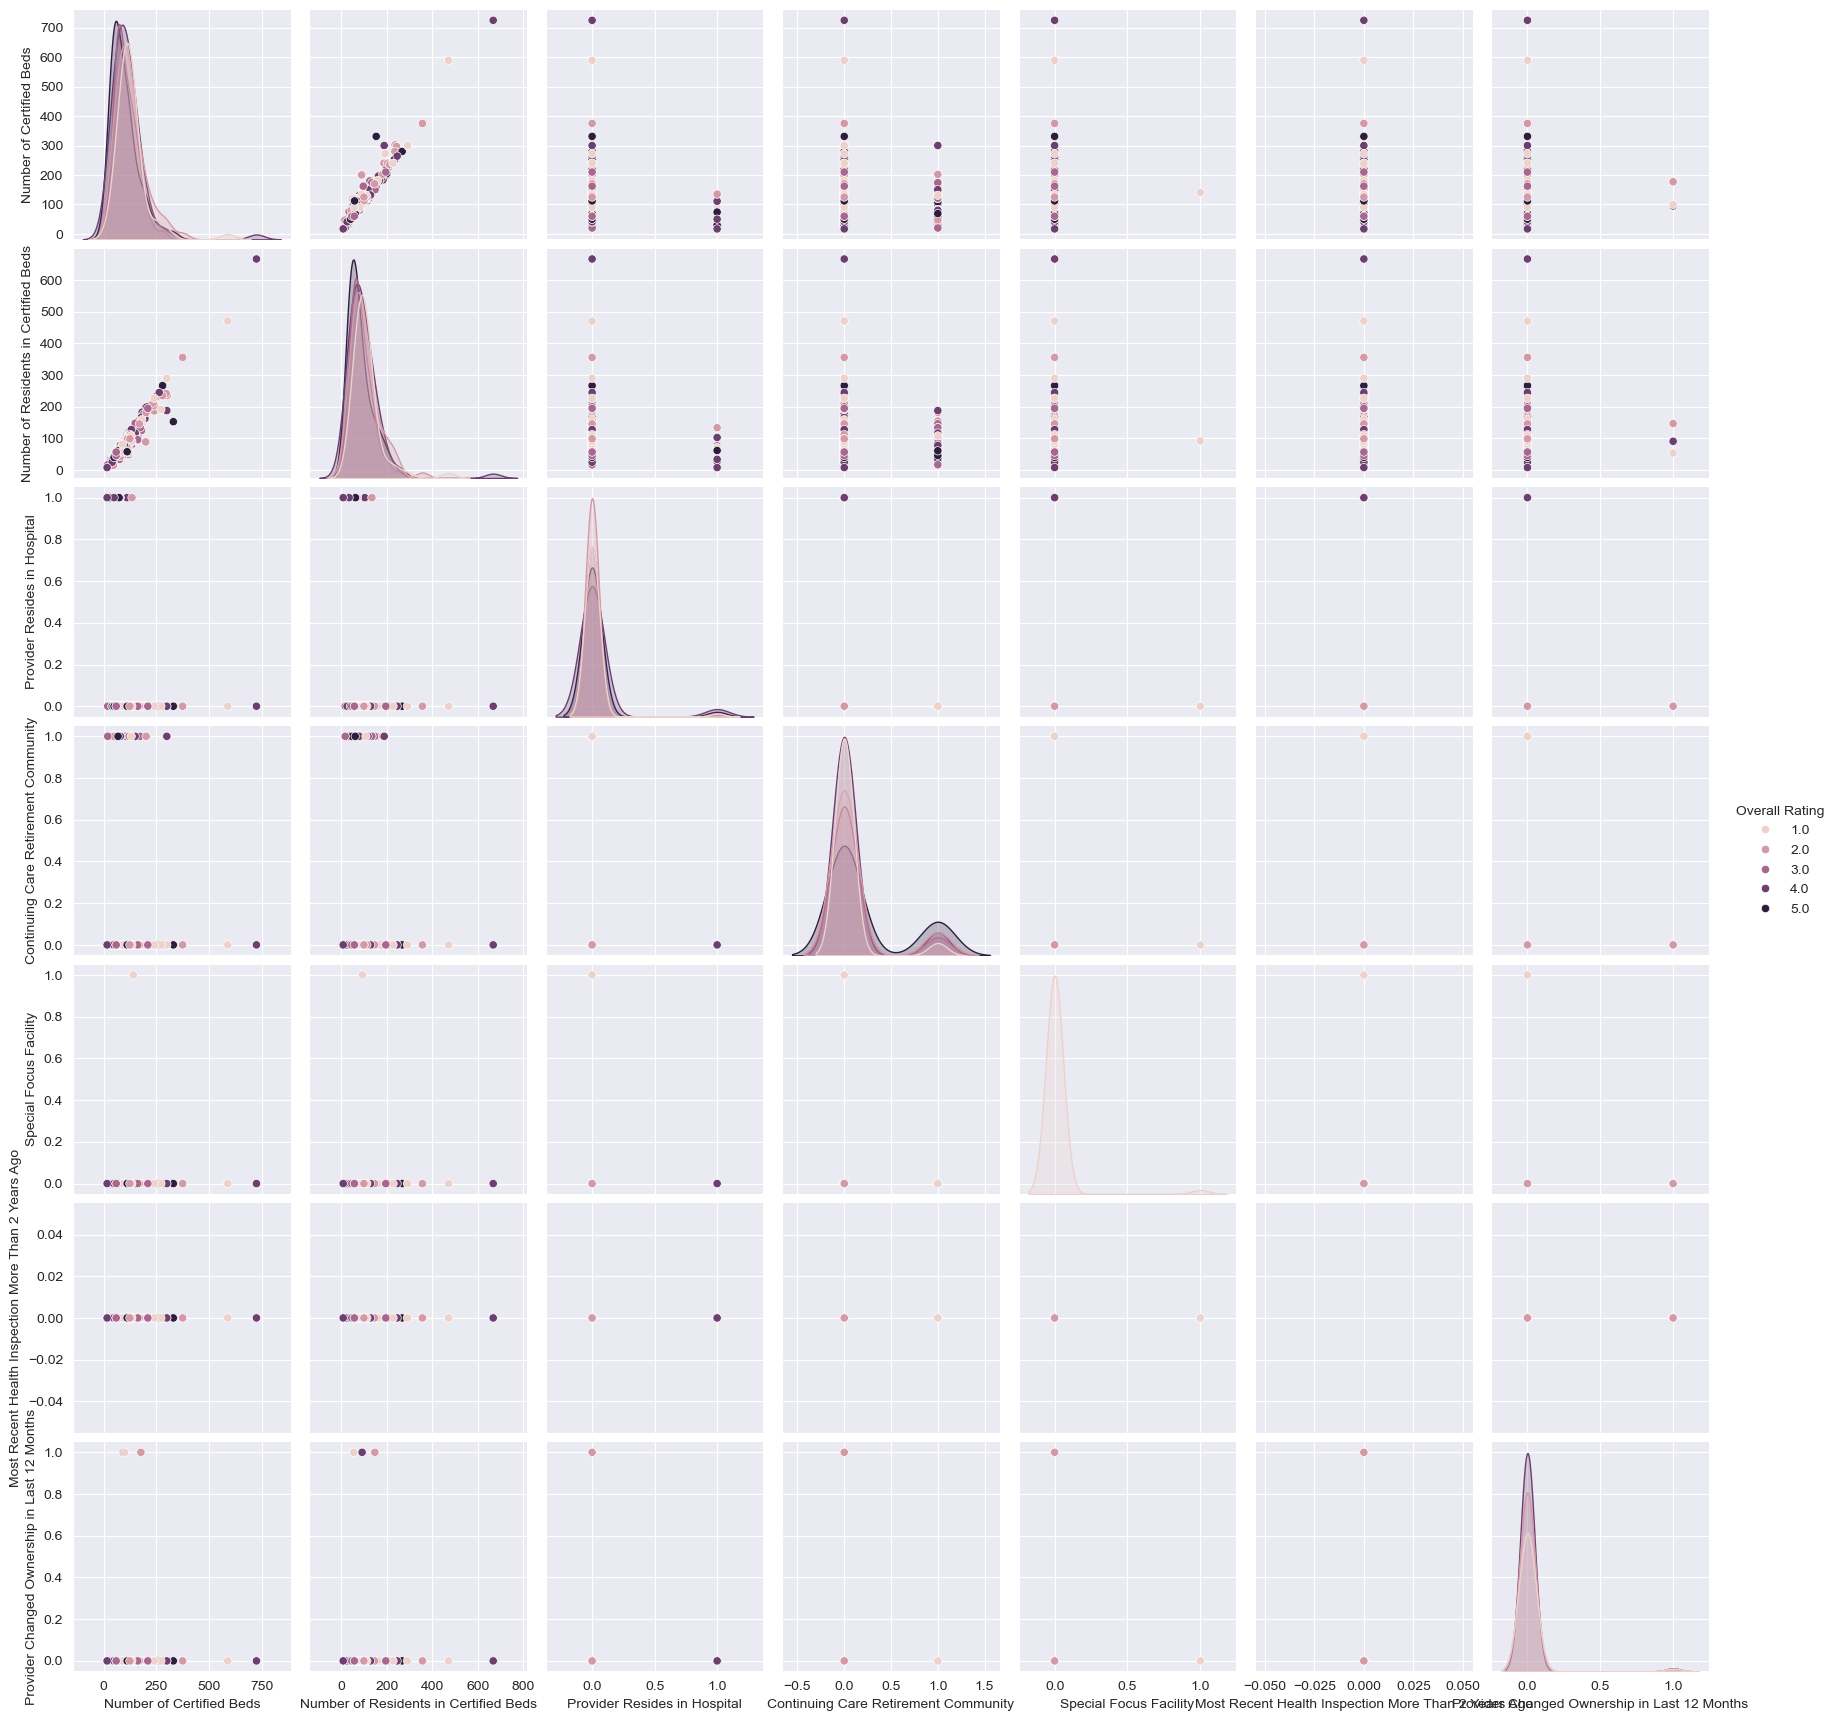

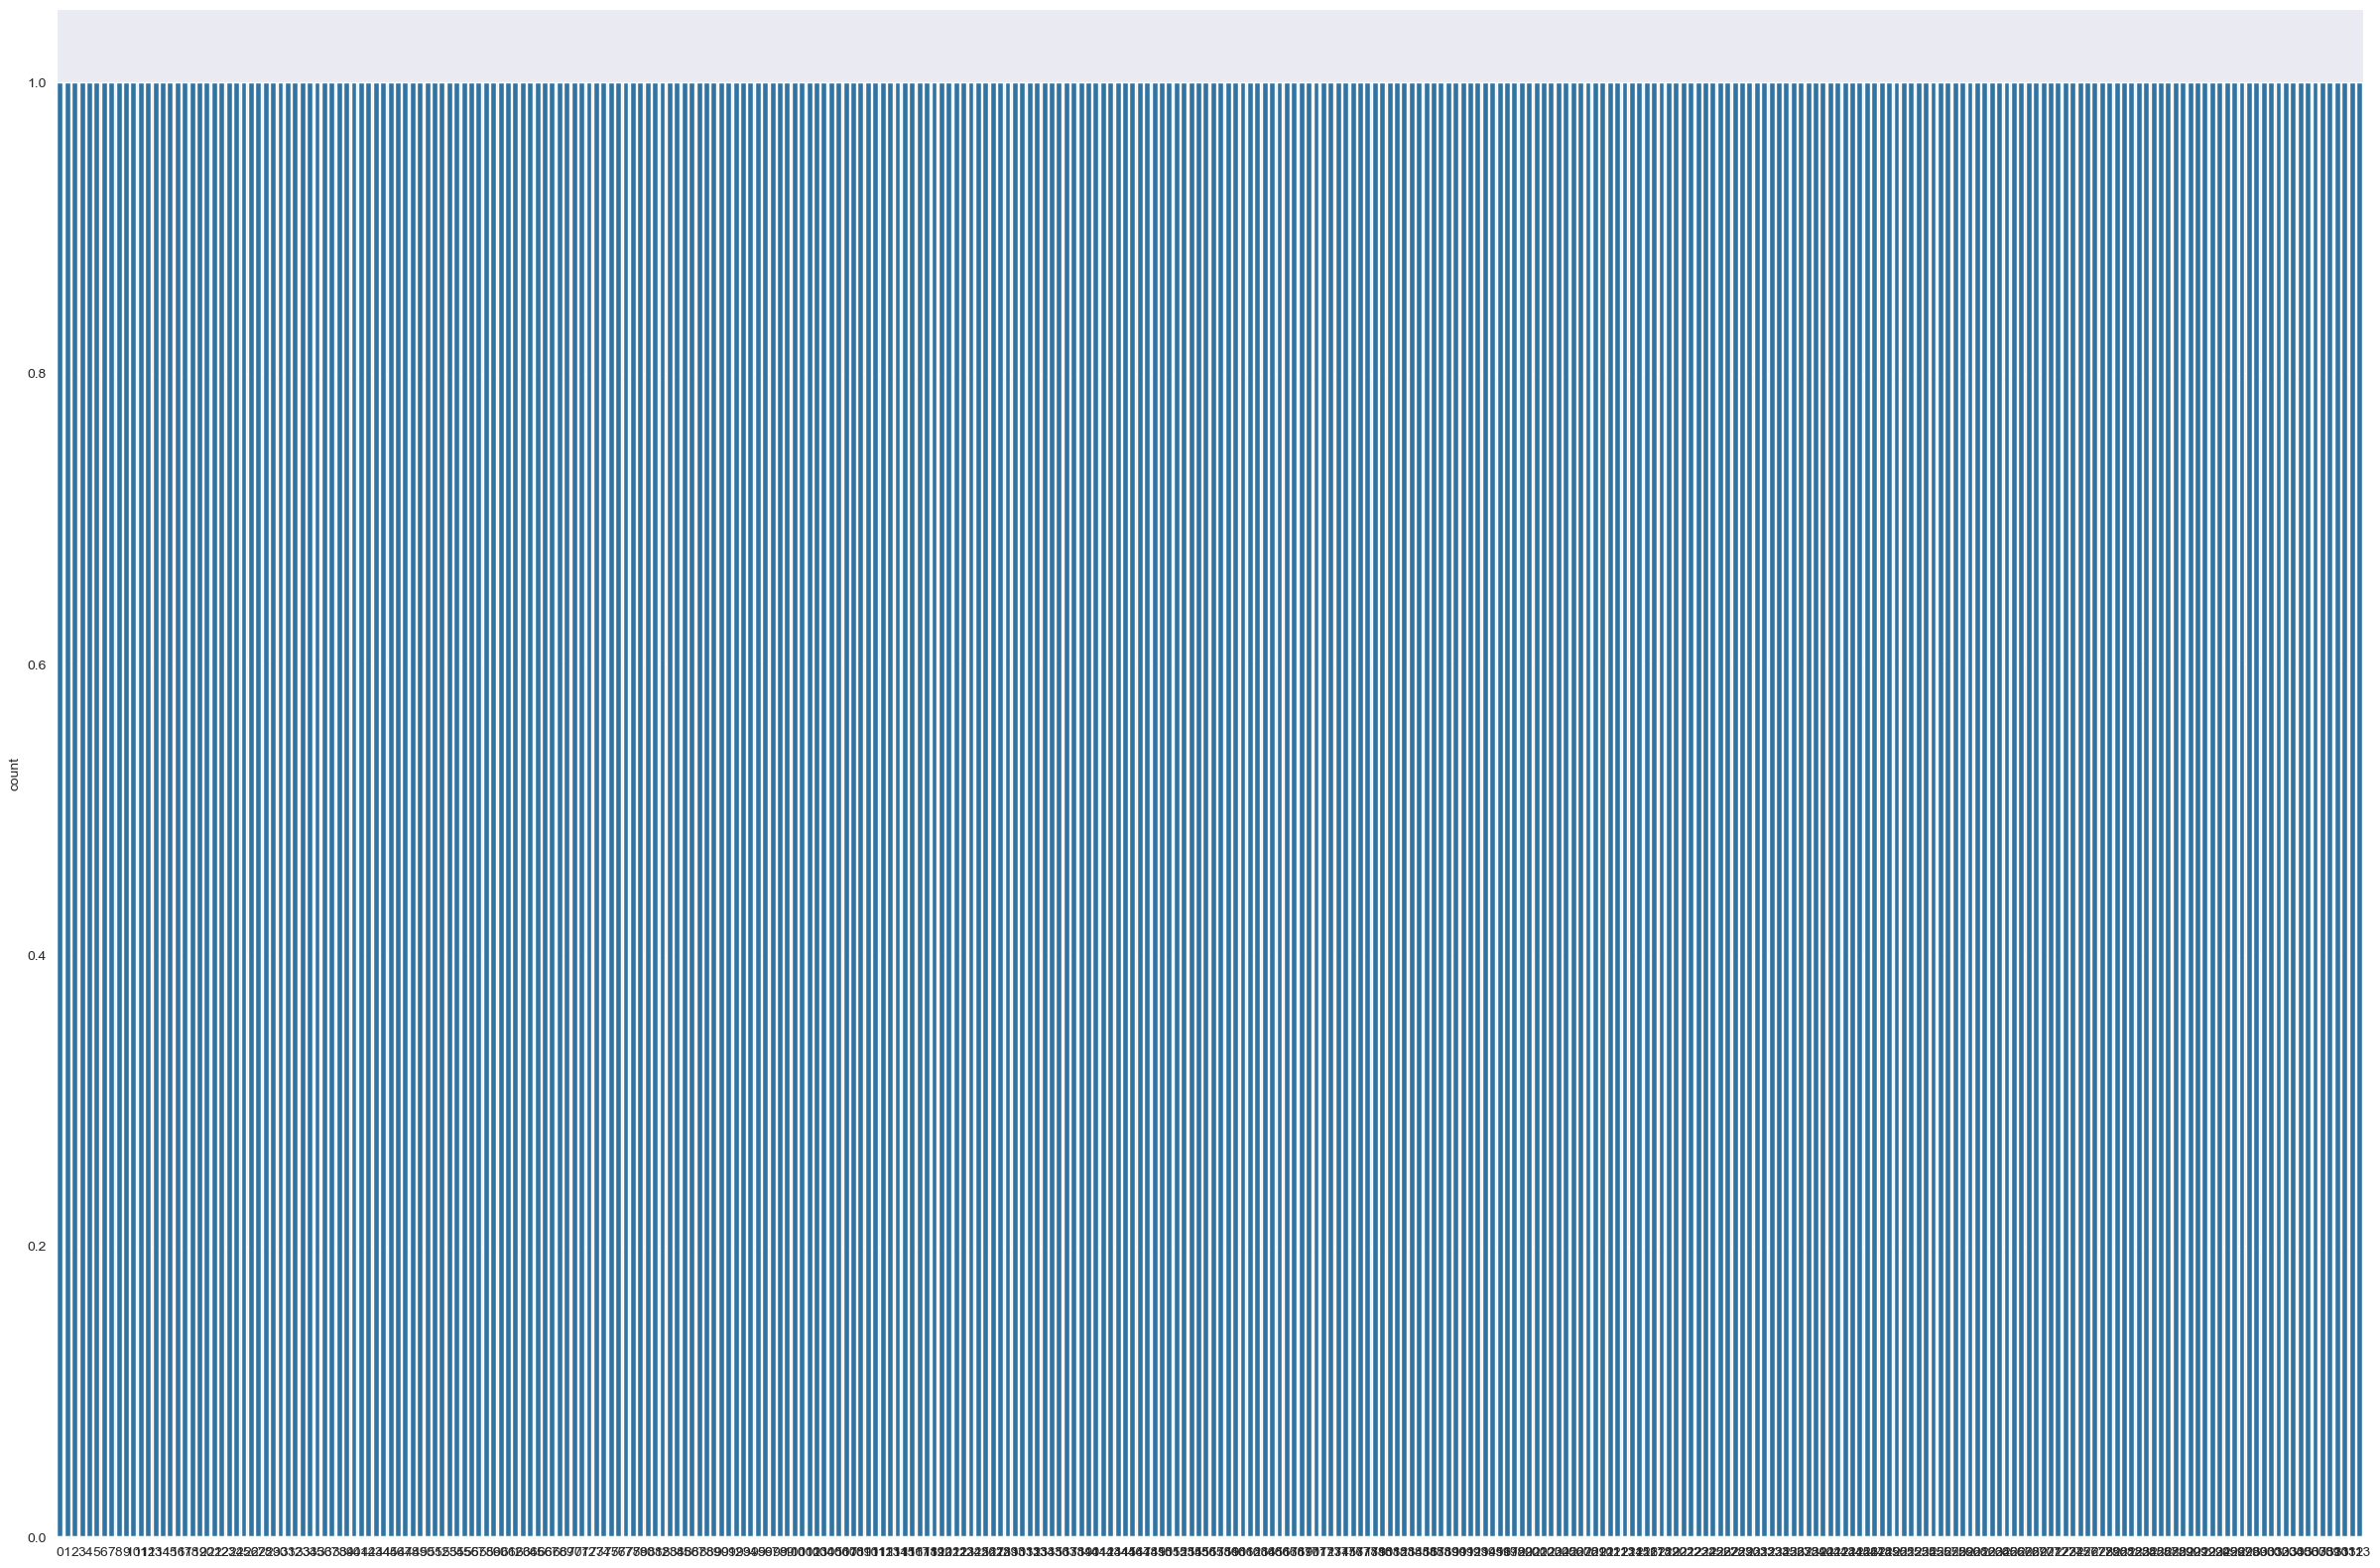

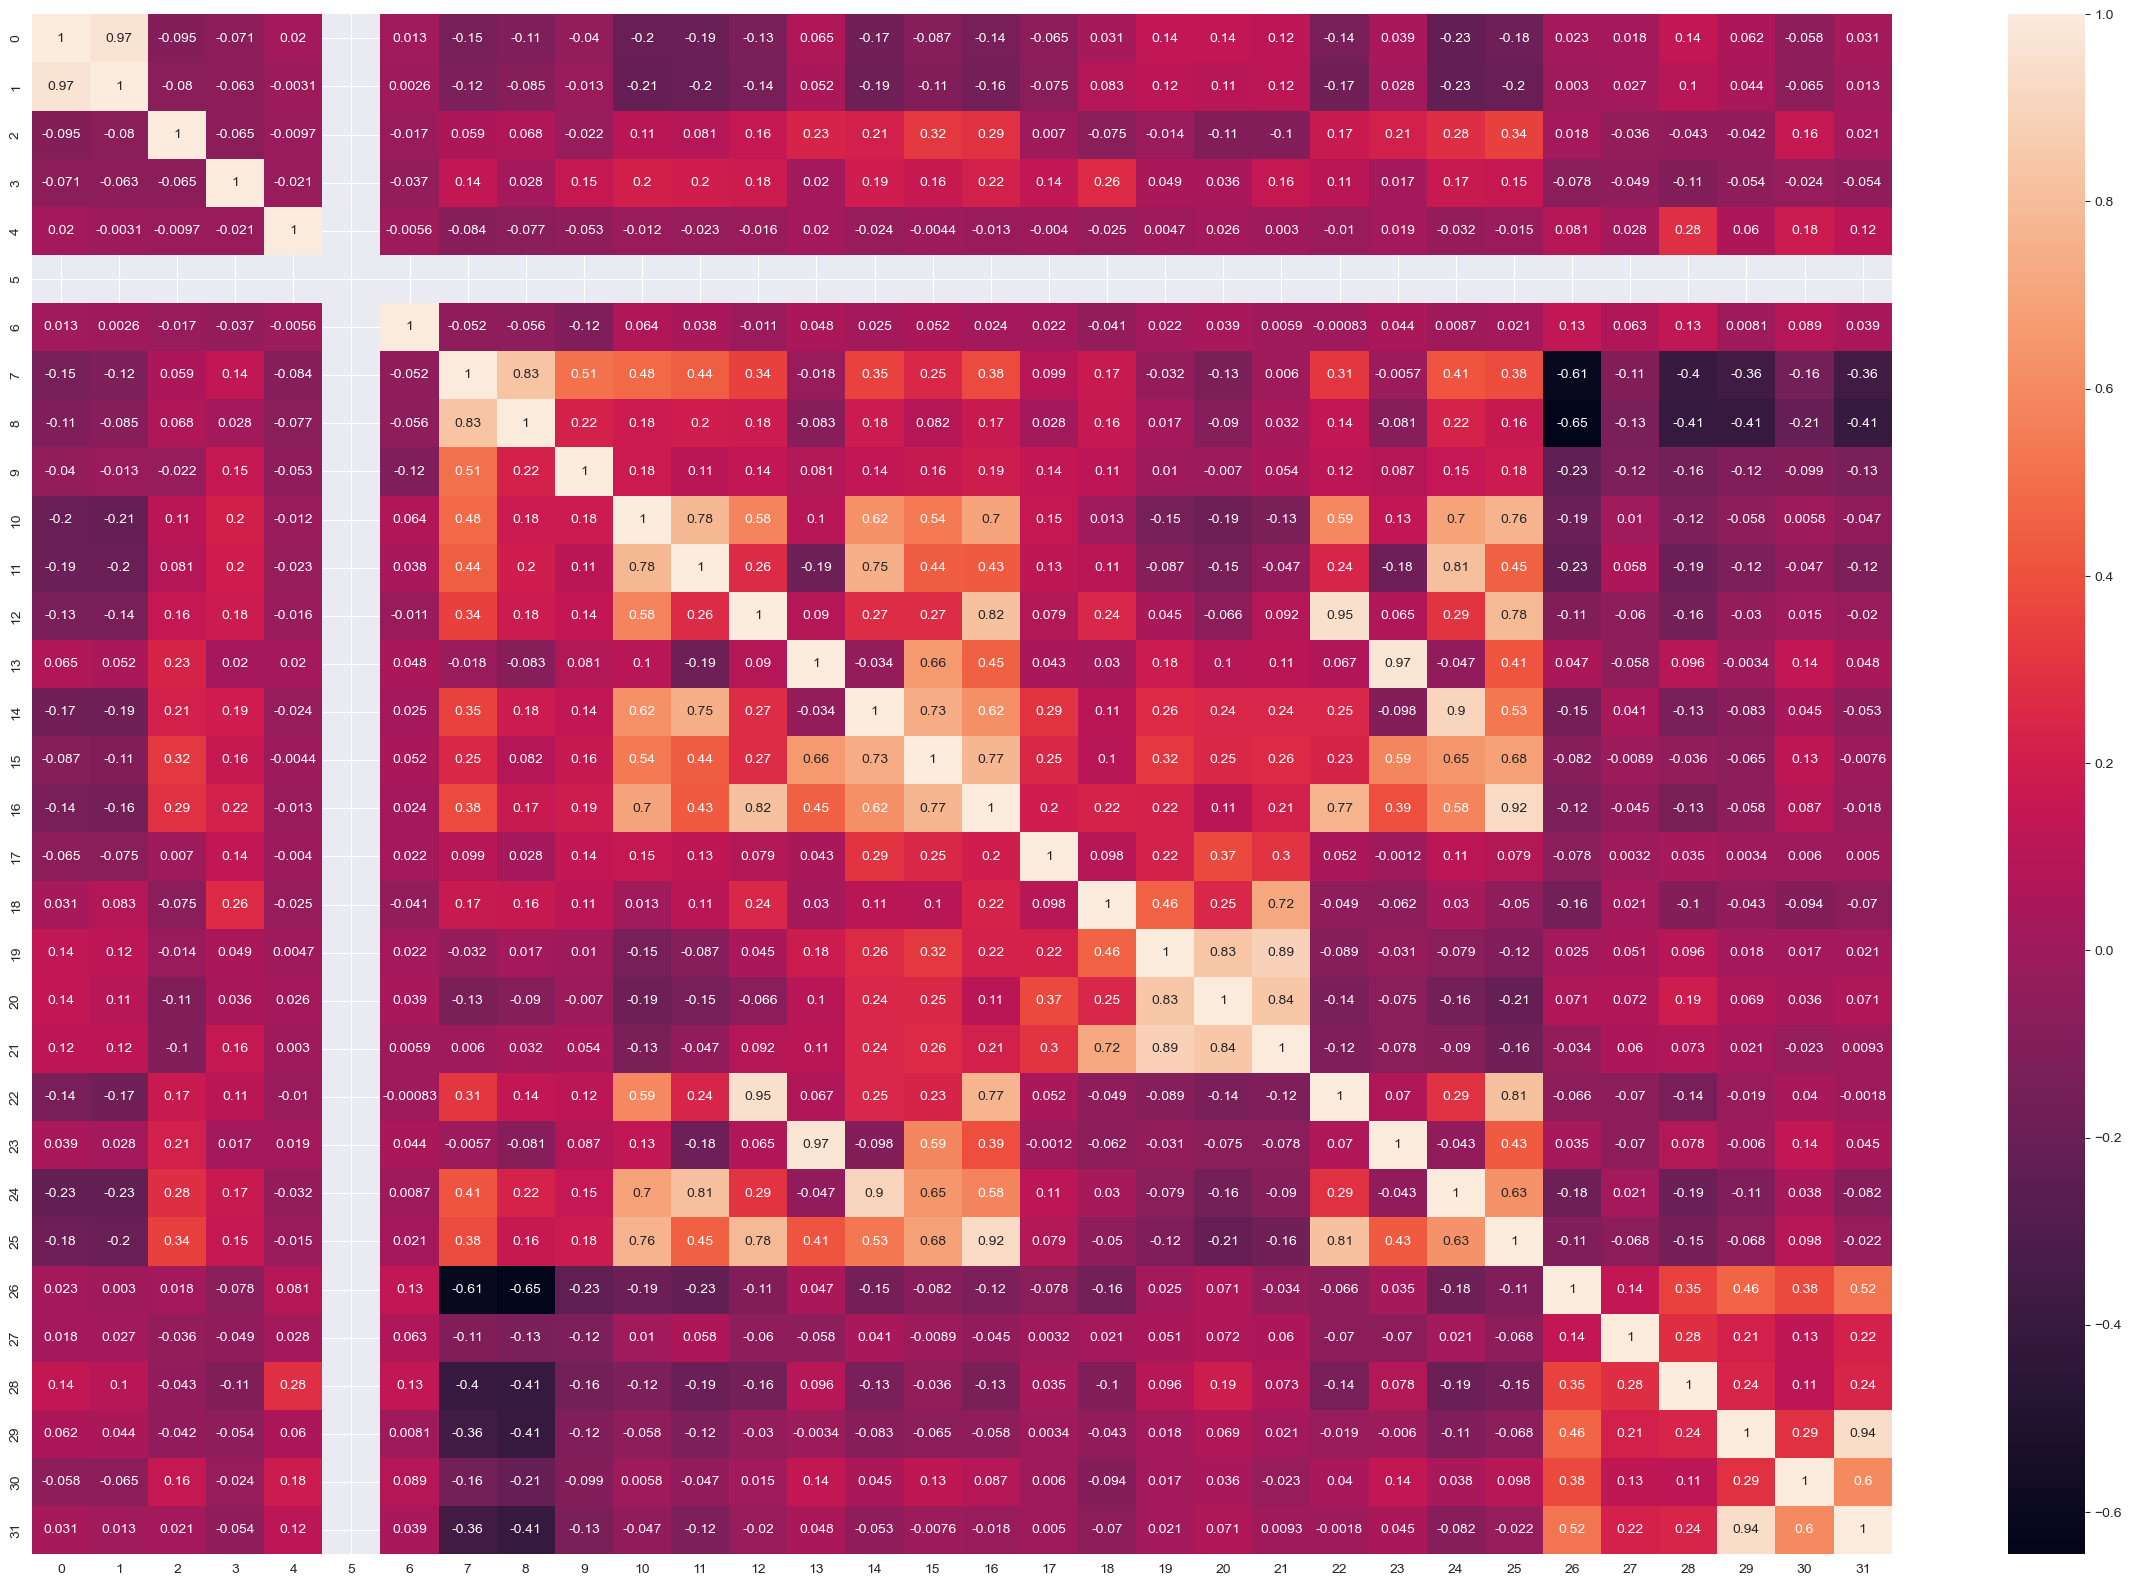

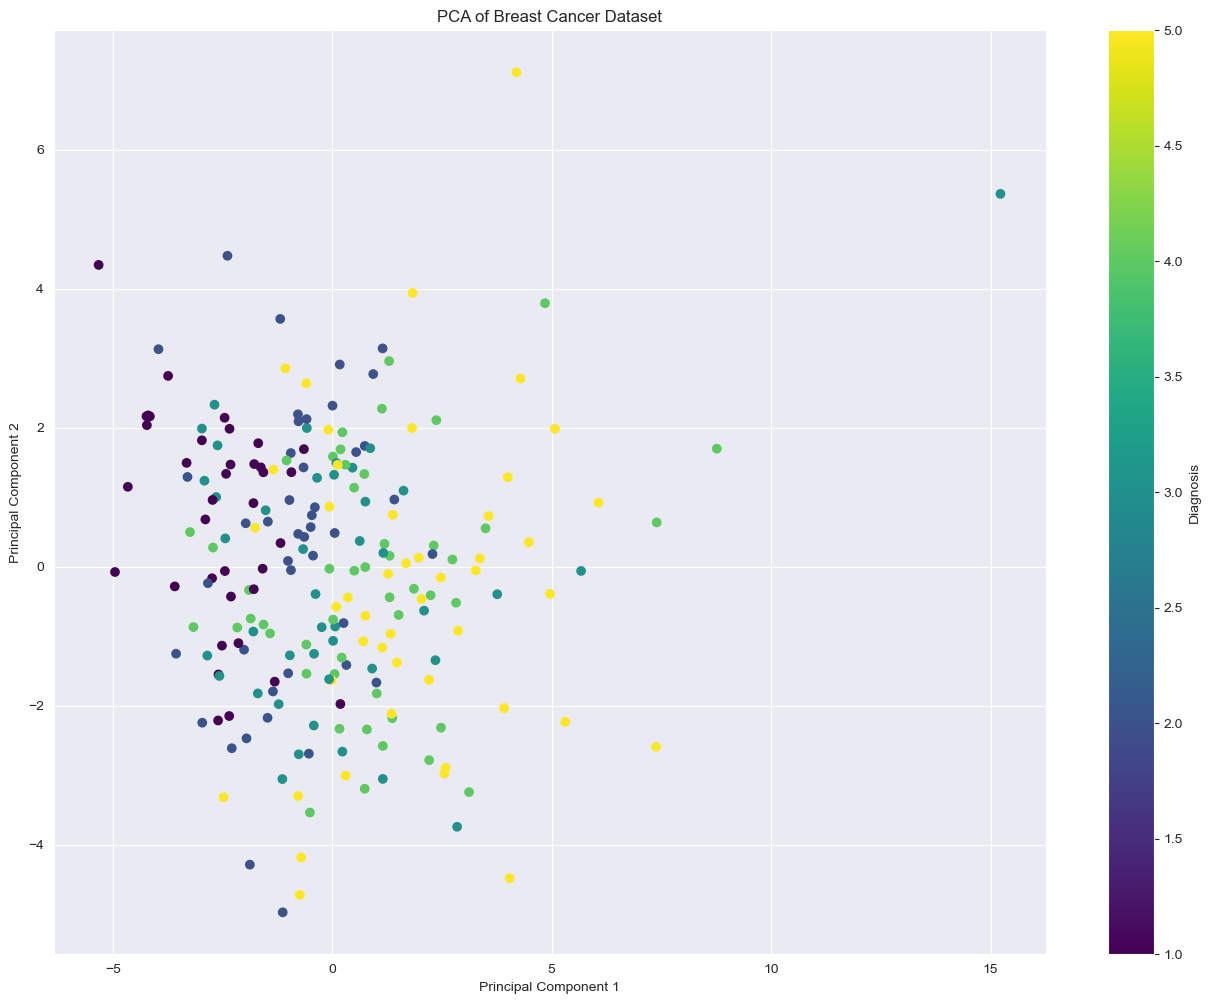

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# IF I CANT CONNECT THESE DATA INTO A SUCCESSFUL MODEL, I WILL SIMPLY CLASSIFY THE OVERALL RATING 
# Separate features and target variable
other=False

if other:
    X = pin.drop('ML_Label_encoded')
    y = pin['ML_Label_encoded']
else:
    #pin = pin.drop('ML_Label_encoded')
    X = pin.drop('Overall Rating')
    y = pin['Overall Rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

comps = int(len(pin.columns) // 3)
# Apply PCA
pca = PCA(n_components=13)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train logistic regression model
logistic_model = LogisticRegression(random_state=32)
logistic_model.fit(X_train_pca, y_train)

# Make predictions
y_pred_pca = logistic_model.predict(X_test_pca)

# Evaluate the model
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy with PCA: {accuracy_pca}")


if other:
    plt.figure(figsize=(30,20))
    sns.pairplot(pin.to_pandas(), hue='ML_Label_encoded', vars=potent[:7])
    
    plt.figure(figsize=(30,20))
    sns.countplot(pin.to_pandas()['ML_Label_encoded'], label = "Count")

    plt.figure(figsize=(30,20)) 
    sns.heatmap(pin.corr(), annot=True)
else:
    plt.figure(figsize=(30,20))
    sns.pairplot(pin.to_pandas(), hue='Overall Rating', vars=potent[:7])
    
    plt.figure(figsize=(30,20))
    sns.countplot(pin.to_pandas()['Overall Rating'], label = "Count")

    plt.figure(figsize=(30,20)) 
    sns.heatmap(pin.corr(), annot=True)
    
# Plot PCA results
plt.figure(figsize=(16, 12))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Breast Cancer Dataset')
plt.colorbar(label='Diagnosis')
plt.show()
